In [80]:
from SimPEG import Mesh, Maps
from simpegEM1D import *
import numpy as np
import matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/srv/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Set up for EM1D program

## Step1: Generate mesh

In [81]:
nearthick = np.logspace(-1, 1, 5)
deepthick = np.logspace(1, 2, 10)
hx = np.r_[nearthick, deepthick]
mesh1D = Mesh.TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
topo = np.r_[0., 0., 0.]

## Step2: Set survey parameters

In [82]:
FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 0.]),
    src_location = np.array([0., 0., 0.]),
    field_type = 'secondary',
    rx_type = 'Hz',
    src_type = 'VMD',
    depth = depth,
    topo = topo,
    frequency = np.logspace(-2, 8, 61),
    offset = 8. * np.ones(61),
    a = 1.,
    I=1.
)

## Step3: Set mappings (Exponential and Cole-Cole maps)

### Exponential map

### $$ m = log(\sigma) $$

### $$ M_{exp}(m) = e^{m}$$

### Cole-Cole map

$$ m(\sigma_{\infty}, \eta, \tau, c; \omega) = \sigma_{\infty} - \sigma_{\infty}\eta \frac{1}{1+(1-\eta)(\imath\omega\tau)^c}$$

In [83]:
sig_half = 1e-2
chi_half = 0.
Expmap = Maps.ExpMap(mesh1D)
tau =  np.ones(nlay, dtype=float)*1e-1
eta = np.ones(nlay, dtype=float)*0.5
c = np.ones(nlay, dtype=float)*0.88

In [84]:
m_1D = np.log(np.ones(nlay)*sig_half)

In [85]:
# Conductivity
prob = EM1D(
    mesh1D, sigmaMap=Expmap,
    chi=np.zeros(FDsurvey.n_layer)
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)
Hz = FDsurvey.dpred(m_1D)

In [86]:
# Frequency-dependent conductivity
probcole = EM1D(
    mesh1D, sigmaMap=Expmap,
    eta=eta, tau=tau, c=c,
    chi=np.zeros(FDsurvey.n_layer)
)
if probcole.ispaired:
    probcole.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
probcole.pair(FDsurvey)
HzCole = FDsurvey.dpred(m_1D)
Hzanal = EM1DAnalytics.Hzanal(sig_half, FDsurvey.frequency, FDsurvey.offset, 'secondary')

In [87]:
Hz_r = Hz.reshape((2, 61))[0,:]

In [90]:
matplotlib.rcParams['font.size'] = 16

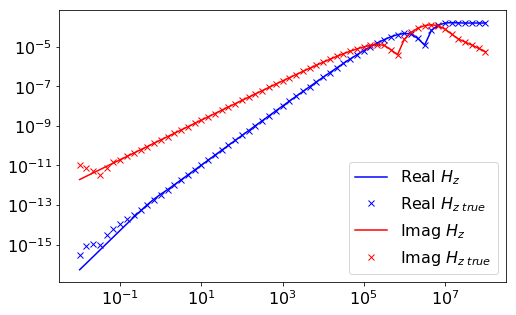

In [91]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))
ax.loglog(FDsurvey.frequency, abs(Hz[:FDsurvey.n_frequency]), 'b-')
ax.loglog(FDsurvey.frequency, abs(Hzanal.real), 'bx')
ax.loglog(FDsurvey.frequency, abs(Hz[FDsurvey.n_frequency:]), 'r-')
ax.loglog(FDsurvey.frequency, abs(Hzanal.imag), 'rx')
legend(('Real $H_{z}$', 'Real $H_{z \ true}$', 'Imag $H_{z}$', 'Imag $H_{z \ true}$'))

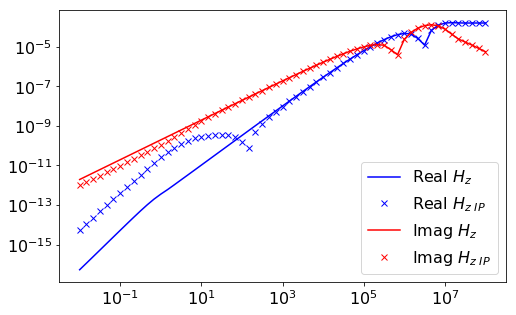

In [93]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))
ax.loglog(FDsurvey.frequency, abs(Hz[:FDsurvey.n_frequency]), 'b-')
ax.loglog(FDsurvey.frequency, abs(HzCole[:FDsurvey.n_frequency]), 'bx')
ax.loglog(FDsurvey.frequency, abs(Hz[FDsurvey.n_frequency:]), 'r-')
ax.loglog(FDsurvey.frequency, abs(HzCole[FDsurvey.n_frequency:]), 'rx')
legend(('Real $H_{z}$', 'Real $H_{z \ IP}$', 'Imag $H_{z}$', 'Imag $H_{z \ IP}$'))